In [6]:
import spatialproteomics as sp
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from scipy.signal import medfilt2d
import numpy as np
from sklearn.cluster import KMeans
import seaborn as sns

In [48]:
ds_2_4 = xr.open_zarr("/dss/dsshome1/00/ge65tib2/Spatialproteomics/Data_zarr/ds_cellpose_2_4_zscore.zarr")
ds_5_5 = xr.open_zarr("/dss/dsshome1/00/ge65tib2/Spatialproteomics/Data_zarr/ds_cellpose_5_5_zscore.zarr")


In [8]:
#ds_2_4 = ds_2_4.transpose("channels", "y", "x", "cells", "features")

In [49]:
ds_2_4

<xarray.Dataset> Size: 280MB
Dimensions:        (channels: 40, y: 2501, x: 2644, cells: 6888, features: 2)
Coordinates:
  * cells          (cells) int64 55kB 1 2 3 4 5 6 ... 6884 6885 6886 6887 6888
  * channels       (channels) <U15 2kB 'DAPI' 'SOX2' 'FAP' ... 'MCT4' 'LAG3'
  * features       (features) <U10 80B 'centroid-0' 'centroid-1'
  * x              (x) int64 21kB 0 1 2 3 4 5 ... 2638 2639 2640 2641 2642 2643
  * y              (y) int64 20kB 0 1 2 3 4 5 ... 2495 2496 2497 2498 2499 2500
Data variables:
    _image         (channels, y, x) uint8 265MB dask.array<chunksize=(5, 626, 661), meta=np.ndarray>
    _intensity     (cells, channels) float64 2MB dask.array<chunksize=(1722, 20), meta=np.ndarray>
    _obs           (cells, features) float64 110kB dask.array<chunksize=(6888, 2), meta=np.ndarray>
    _segmentation  (y, x) uint16 13MB dask.array<chunksize=(626, 661), meta=np.ndarray>

In [50]:
ds_5_5

<xarray.Dataset> Size: 365MB
Dimensions:        (channels: 40, y: 2792, x: 3084, cells: 10593, features: 2)
Coordinates:
  * cells          (cells) int64 85kB 1 2 3 4 5 ... 10590 10591 10592 10593
  * channels       (channels) <U15 2kB 'DAPI' 'SOX2' 'FAP' ... 'MCT4' 'LAG3'
  * features       (features) <U10 80B 'centroid-0' 'centroid-1'
  * x              (x) int64 25kB 0 1 2 3 4 5 ... 3078 3079 3080 3081 3082 3083
  * y              (y) int64 22kB 0 1 2 3 4 5 ... 2786 2787 2788 2789 2790 2791
Data variables:
    _image         (channels, y, x) uint8 344MB dask.array<chunksize=(5, 349, 771), meta=np.ndarray>
    _intensity     (cells, channels) float64 3MB dask.array<chunksize=(2649, 20), meta=np.ndarray>
    _obs           (cells, features) float64 169kB dask.array<chunksize=(10593, 2), meta=np.ndarray>
    _segmentation  (y, x) uint16 17MB dask.array<chunksize=(349, 771), meta=np.ndarray>

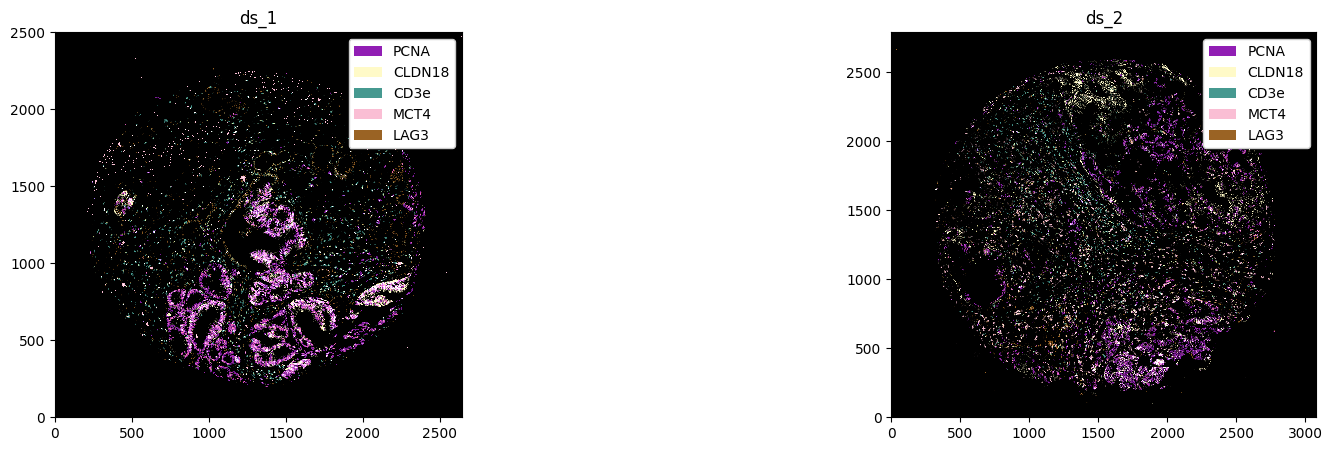

In [44]:

channels = ['SOX2', 'FAP', 'cxcr3', 'LRRC15', 'CD20', 'CD68', 'CD45RO', 'CD31', 'PD-1', 'Ki67', 'Keratin 5', 'CD4', 'IFNG', 'SMA', 'CD66', 'Podoplanin', 'CXCR4', 'PGRN', 'Granzyme B', 'Pan-Cytokeratin', 'MARCO', 'CD56', 'HAS1', 'CD107a', 'b-Catenin1', 'HLA-A', 'HLA-DR', 'CD8', 'PDL1', 'TP63', 'GATA6', 'CD34', 'TCF-1', 'Bcl-2', 'PCNA', 'CLDN18', 'CD3e', 'MCT4', 'LAG3']
colors = [
    "#911eb4",
    "#fffac8",
    "#469990",
    "#fabed4",
    "#9A6324",
]
channels_celltypes = channels[-5:]
# plotting the ds and ds processed next to one another

fig, axes = plt.subplots(1, 2, figsize=(20, 5))  # 一行五图，可根据需要调整布局

_ = ds_2_4.pp[channels_celltypes].pl.colorize(colors).pl.show(ax=axes[0])
_ = ds_5_5.pp[channels_celltypes].pl.colorize(colors).pl.show(ax=axes[1])


# 添加标题（可选）
for i, ax in enumerate(axes):
    ax.set_title(f"ds_{i+1}")





In [17]:
marker_dict = {
    "Pan-Cytokeratin": "Epithelial",
    "TP63": "basal tumor cells",
    "Keratin 5": "basal tumor cells",
    "CLDN18": "classical tumor cells",
    "GATA6": "classical tumor cells",
    "CD3e": "T cells",
    "CD4": "Helper T cells",
    "CD8": "Cytotoxic T cells",
    "CD45RO": "Memory T cells",
    "PD-1": "Immune Check-point",
    "PDL1": "Immune Check-point",
    "LAG3": "Immune Check-point",
    "IFNG": "Cytotoxic T cells or NK cells",
    "CD20": "B cells",
    "CD68": "Macrophages",
    "MARCO": "M2-Macrophages",
    "CD107a": "Cytotoxic T cells or NK cells",
    "HLA-A": "APC",
    "HLA-DR": "APC",
    "SOX2": "SOX2+",
    "CXCR4": "iCAFs",
    "TCF-1": "Cytotoxic T cells",
    "FAP": "myCAFs",
    "SMA": "myCAFs",
    "HAS1": "iCAFs",
    "LRRC15": "myCAFs",
    "Ki67": "Proliferating",
    "PCNA": "Proliferating",
    "MCT4": "MCT4+",
    "CD56": "NK cells",
    "Granzyme B": "Cytotoxic T cells or NK cells",
    "CD31": "Endothelial cells",
    "CD34": "Endothelial cells",
    "Bcl-2": "Anti-apoptosis",
    "cxcr3": "Cytotoxic T cells",
    "Podoplanin": "myCAFs",
    "CD66": "Neutrophils",
    "PGRN": "PGRN+",
    "b-Catenin1": "b-Catenin1+",

}

In [18]:
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np


# 从三个 matplotlib colormap 中获取颜色
colors = list(cm.tab20(np.linspace(0, 1, 20))) + \
         list(cm.tab20b(np.linspace(0, 1, 10))) + \
         list(cm.tab20c(np.linspace(0, 1, 9)))  # 共 39 个颜色


# predicting the cell type using the argmay
ds_2_4_predictions = ds_2_4.la.predict_cell_types_argmax(
    marker_dict, key="_intensity", overwrite_existing_labels=True
)

# adding colors to match the markers

ds_2_4_predictions = ds_2_4_predictions.la.set_label_colors(list(marker_dict.values()), colors)

# predicting the cell type using the argmay
ds_5_5_predictions = ds_5_5.la.predict_cell_types_argmax(
    marker_dict, key="_intensity", overwrite_existing_labels=True
)

# adding colors to match the markers

ds_5_5_predictions = ds_5_5_predictions.la.set_label_colors(list(marker_dict.values()), colors)

Text(0.5, 1.0, 'Cell Type Predictions')

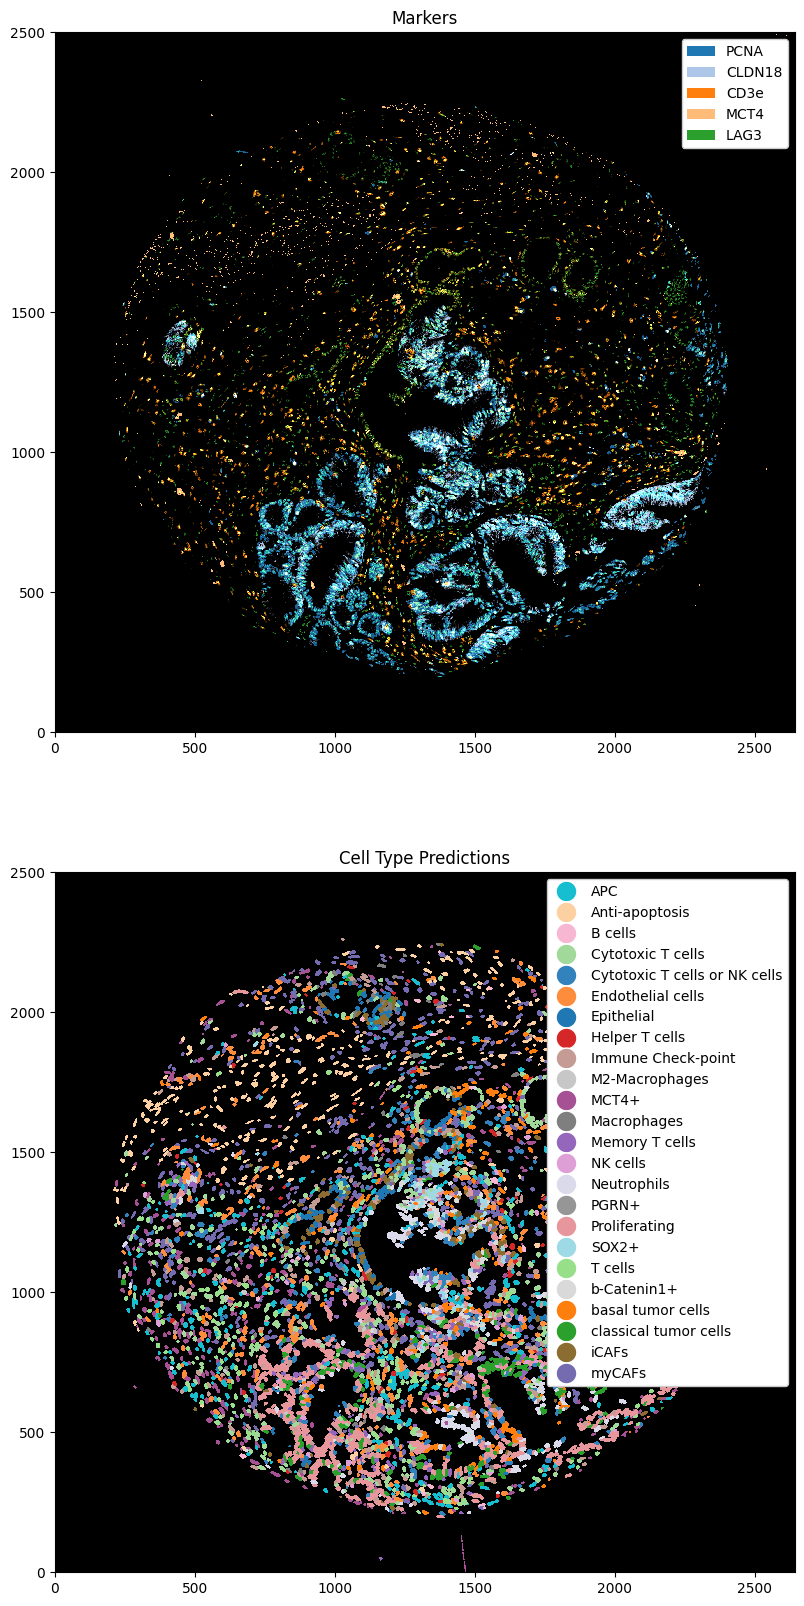

In [19]:
# plotting the ct predictions next to the processed image
fig, ax = plt.subplots(2, 1, figsize=(20, 20))

_ = ds_2_4_predictions.pp[channels_celltypes].pl.colorize(colors).pl.show(ax=ax[0])
_ = ds_2_4_predictions.pl.show(render_image=False, render_labels=True, ax=ax[1])

ax[0].set_title("Markers")
ax[1].set_title("Cell Type Predictions")

Text(0.5, 1.0, 'Cell Type Predictions')

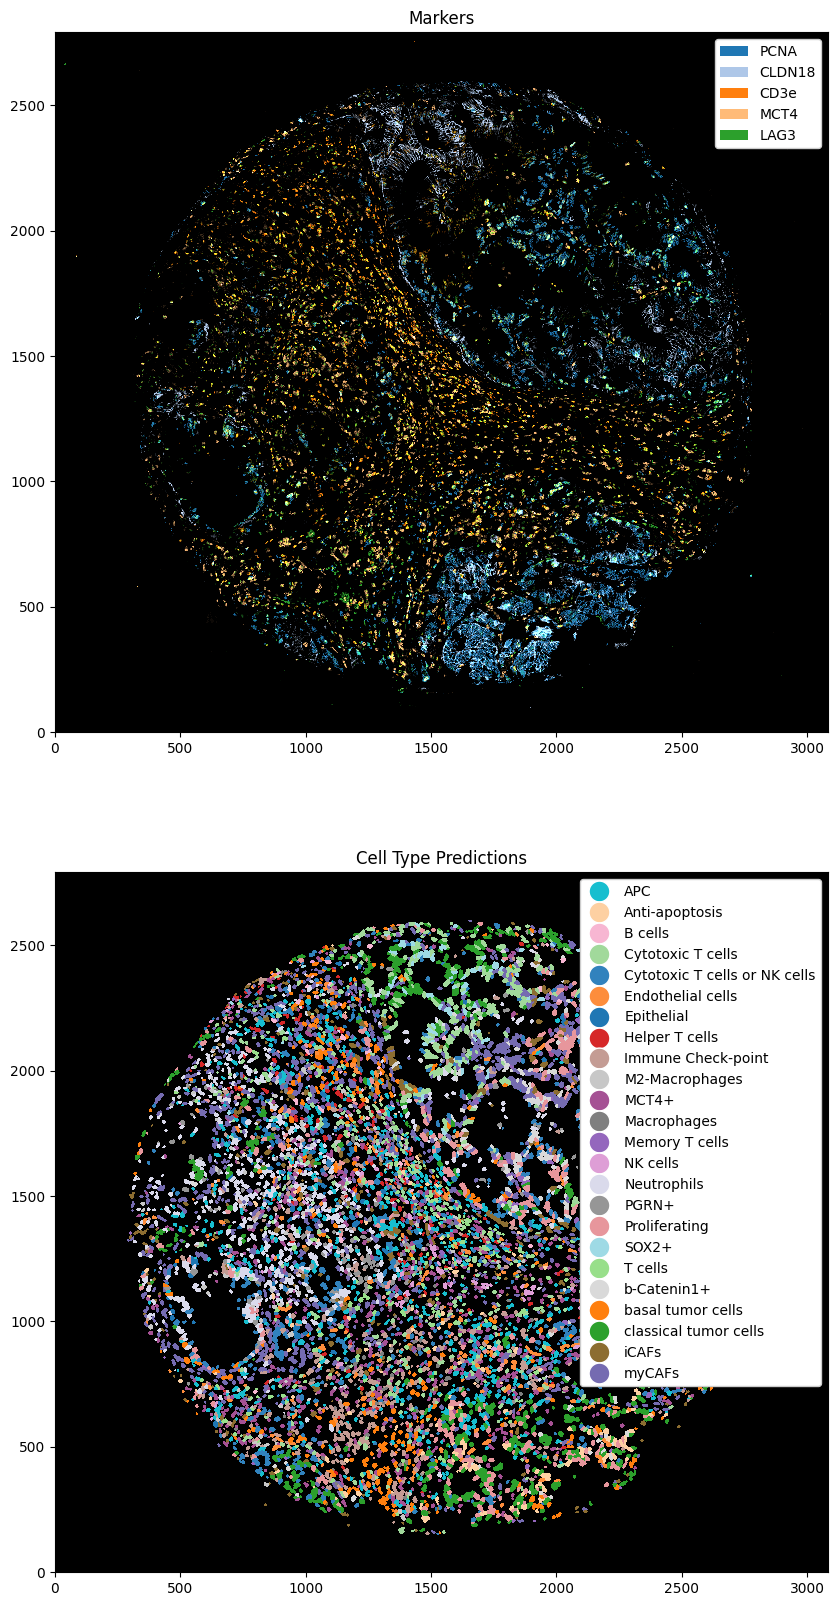

In [20]:
# plotting the ct predictions next to the processed image
fig, ax = plt.subplots(2, 1, figsize=(20, 20))

_ = ds_5_5_predictions.pp[channels_celltypes].pl.colorize(colors).pl.show(ax=ax[0])
_ = ds_5_5_predictions.pl.show(render_image=False, render_labels=True, ax=ax[1])

ax[0].set_title("Markers")
ax[1].set_title("Cell Type Predictions")

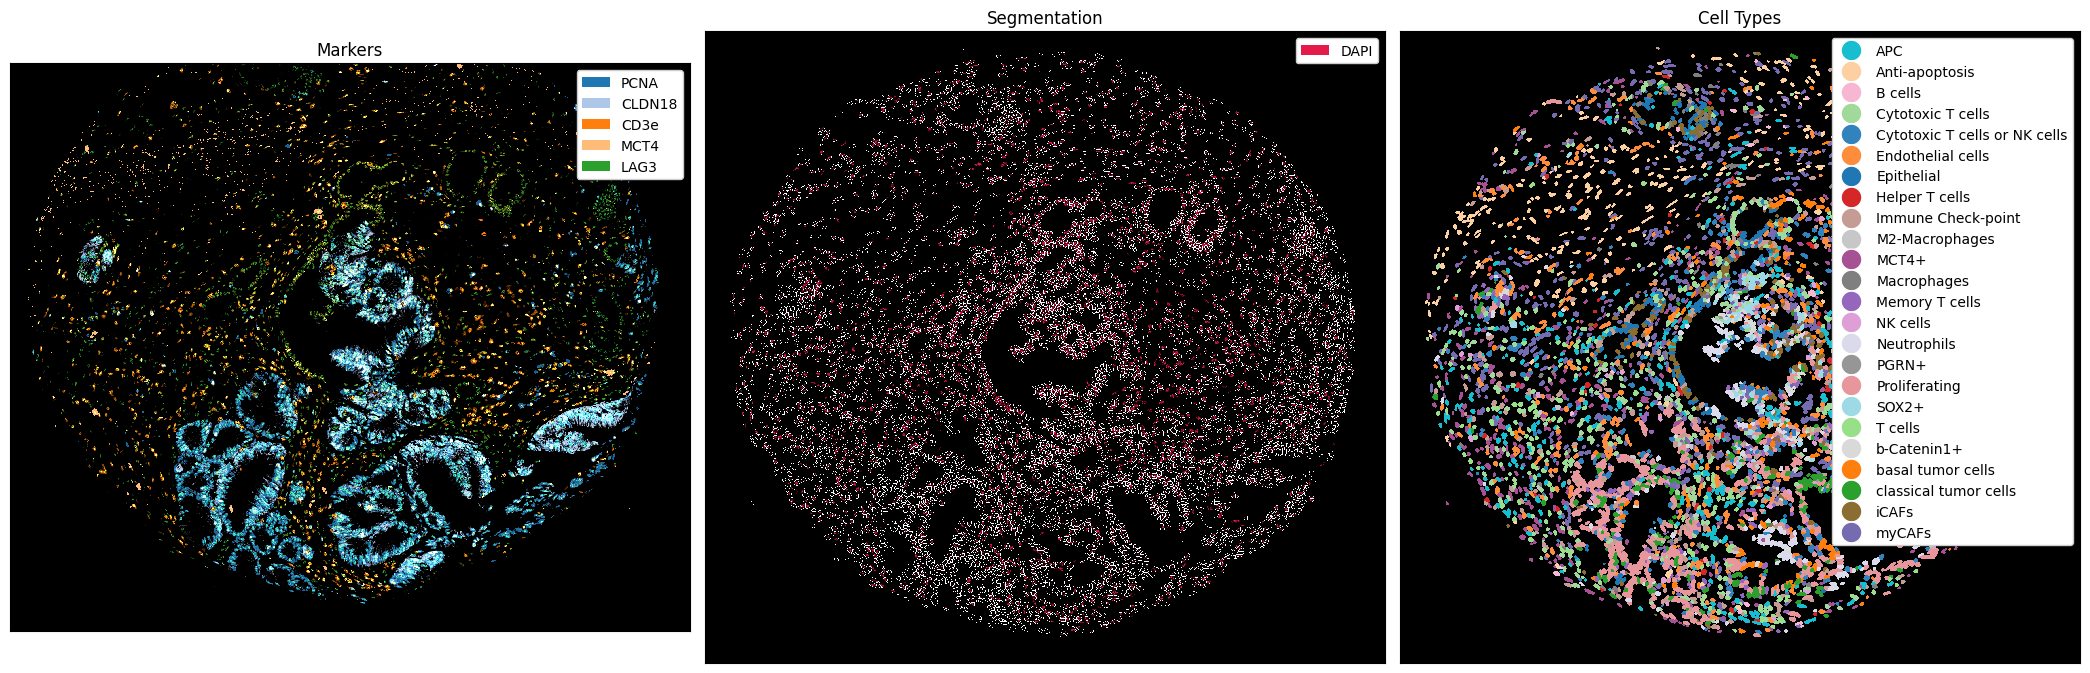

In [21]:
# this is how the image in the README was created
fig, ax = plt.subplots(1, 3, figsize=(21, 7))
_ = ds_2_4.pp[channels_celltypes].pl.colorize(colors).pl.autocrop(padding=100).pl.show(ax=ax[0])
_ = ds_2_4.pp["DAPI"].pl.autocrop(padding=100).pl.show(render_segmentation=True, ax=ax[1])
_ = ds_2_4_predictions.pl.autocrop(padding=100).pl.show(render_image=False, render_labels=True, ax=ax[2])


# removing the x and y ticks
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[2].set_xticks([])
ax[2].set_yticks([])

# setting titles
ax[0].set_title("Markers")
ax[1].set_title("Segmentation")
ax[2].set_title("Cell Types")

plt.tight_layout()

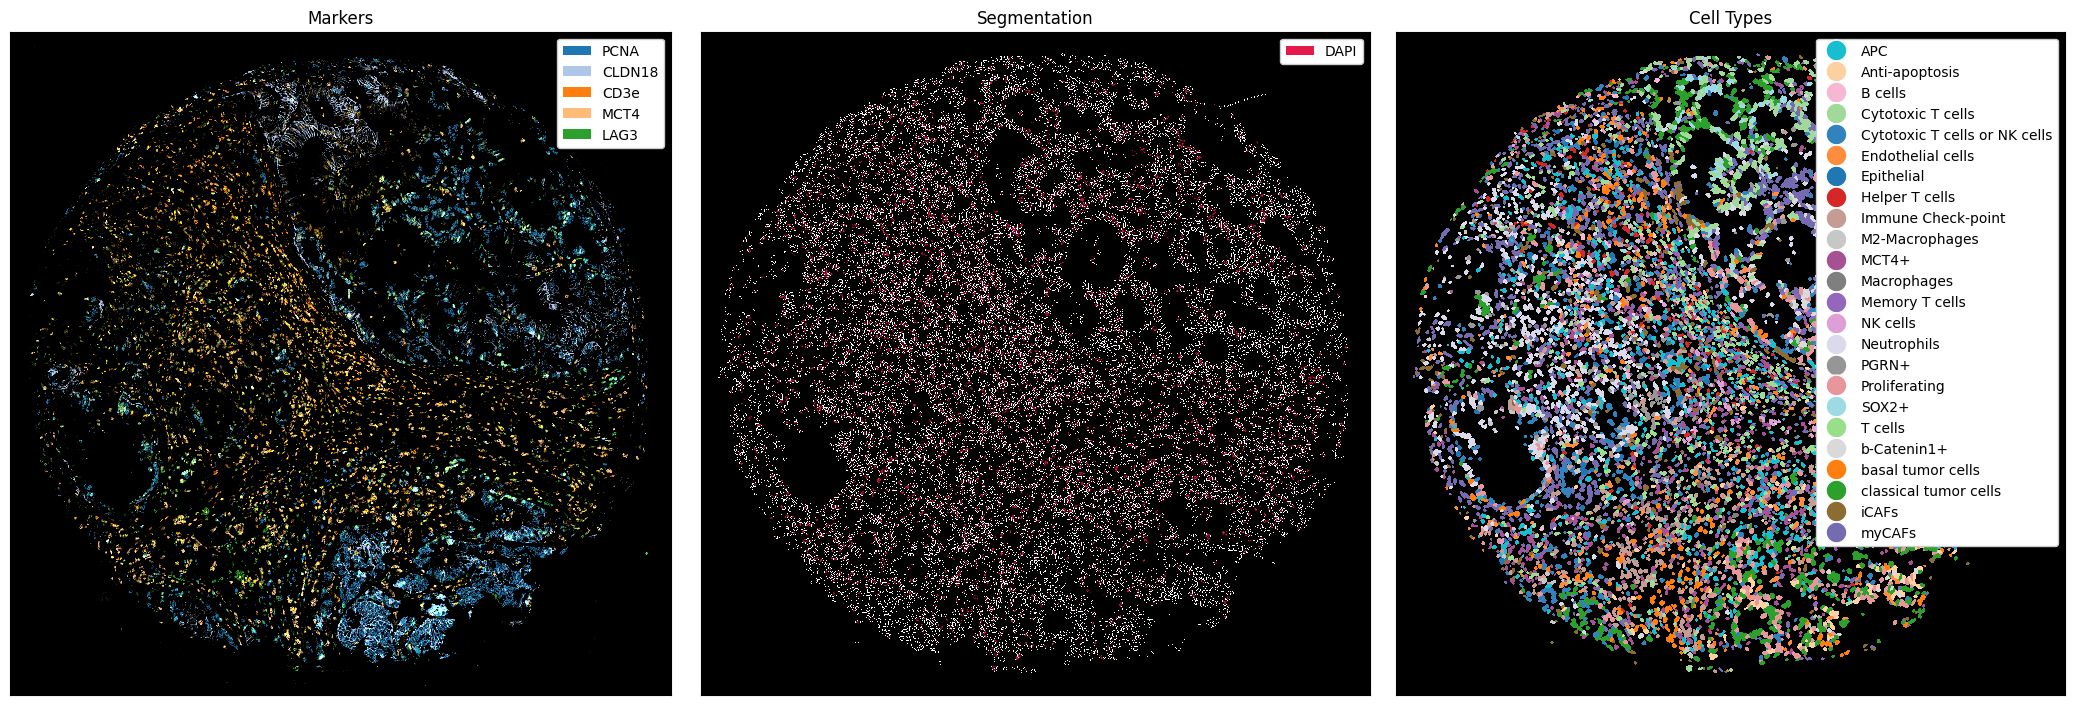

In [22]:
# this is how the image in the README was created
fig, ax = plt.subplots(1, 3, figsize=(21, 7))
_ = ds_5_5.pp[channels_celltypes].pl.colorize(colors).pl.autocrop(padding=100).pl.show(ax=ax[0])
_ = ds_5_5.pp["DAPI"].pl.autocrop(padding=100).pl.show(render_segmentation=True, ax=ax[1])
_ = ds_5_5_predictions.pl.autocrop(padding=100).pl.show(render_image=False, render_labels=True, ax=ax[2])


# removing the x and y ticks
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[2].set_xticks([])
ax[2].set_yticks([])

# setting titles
ax[0].set_title("Markers")
ax[1].set_title("Segmentation")
ax[2].set_title("Cell Types")

plt.tight_layout()

In [23]:
ds_2_4_predictions.pp.get_layer_as_df("_obs", celltypes_to_str=True)

_labels   centroid-0   centroid-1
1                             MCT4+    62.866848  1456.899457
2                             MCT4+    69.323944  1456.610329
3                    Memory T cells    47.083333  1161.975000
4                     Proliferating   197.530000  1375.023333
5     Cytotoxic T cells or NK cells   209.043165  1381.032374
...                             ...          ...          ...
6884                          MCT4+  2233.961905  1342.876190
6885                 Anti-apoptosis  2235.630872  1299.161074
6886                          iCAFs  2240.331250  1379.506250
6887                    Macrophages  2242.033613  1366.310924
6888             Immune Check-point  2259.953704  1026.555556

[6888 rows x 3 columns]

In [24]:
ds_5_5_predictions.pp.get_layer_as_df("_obs", celltypes_to_str=True)

_labels   centroid-0   centroid-1
1                 Immune Check-point   153.576720  1483.925926
2      Cytotoxic T cells or NK cells   152.153846  1525.318681
3                  basal tumor cells   156.590909  1533.784091
4                  Cytotoxic T cells   158.745192  1382.615385
5                             myCAFs   159.831633  1506.280612
...                              ...          ...          ...
10589              Cytotoxic T cells  2585.418301  1428.098039
10590                          iCAFs  2585.836842  1823.531579
10591              Cytotoxic T cells  2585.187500  1459.982955
10592              Cytotoxic T cells  2585.757353  1578.838235
10593                         myCAFs  2596.611650  1654.242718

[10593 rows x 3 columns]

In [26]:
seg_2_4 = ds_2_4["_segmentation"].values

ds_for_astir_2_4 = (
    ds_2_4
    .pp.drop_layers("_obs")
    .pp.add_segmentation(seg_2_4)           # 添加 stardist segmentation，并命名为 "_segmentation"
)

In [52]:
seg_5_5 = ds_5_5["_segmentation"].values

ds_for_astir_5_5 = (
    ds_5_5
    .pp.drop_layers("_obs")
    .pp.add_segmentation(seg_5_5)           # 添加segmentation，并命名为 "_segmentation"
)
ds_for_astir_5_5 = ds_for_astir_5_5.clip(lower=-5, upper=5)

TypeError: DataWithCoords.clip() got an unexpected keyword argument 'lower'

In [28]:
ds_for_astir_2_4


<xarray.Dataset> Size: 280MB
Dimensions:        (channels: 40, y: 2501, x: 2644, cells: 6888, features: 2)
Coordinates:
  * channels       (channels) <U15 2kB 'DAPI' 'SOX2' 'FAP' ... 'MCT4' 'LAG3'
  * x              (x) int64 21kB 0 1 2 3 4 5 ... 2638 2639 2640 2641 2642 2643
  * y              (y) int64 20kB 0 1 2 3 4 5 ... 2495 2496 2497 2498 2499 2500
  * cells          (cells) int64 55kB 1 2 3 4 5 6 ... 6884 6885 6886 6887 6888
  * features       (features) <U10 80B 'centroid-0' 'centroid-1'
Data variables:
    _image         (channels, y, x) uint8 265MB dask.array<chunksize=(5, 626, 661), meta=np.ndarray>
    _intensity     (cells, channels) float64 2MB dask.array<chunksize=(1722, 20), meta=np.ndarray>
    _segmentation  (y, x) uint16 13MB 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    _obs           (cells, features) float64 110kB 62.87 1.457e+03 ... 1.027e+03

In [47]:
# using astir to predict cell types
# note the slightly different structure of the marker dictionary
ct_marker_dict = {
    "cell_type": {
        "B": ["CD20"],
        "T": ["CD3e"],
        "Cytotoxic T or NK": ["IFNG"],
        "Cytotoxic T": ["TCF-1"],
        "Helper T": ["CD4"],
        "Cytotoxic T": ["CD8"],
        "Cytotoxic T or NK": ["CD107a"],
        "Cytotoxic T": ["cxcr3"],
        "Macro": ["CD68"],
        "M2-Macro": ["MARCO"],
        "myCAFs": ["Podoplanin"],
        "Endothelial cells": ["CD31"],
        "Endothelial cells": ["CD34"],
        "NK": ["CD56"],
        "classical tumor cells": ["CLDN18"],
        "classical tumor cells": ["GATA6"],
        "Immune-checkpoint": ["PDL1"],
        "SOX2+": ["SOX2"],
        "MCT4+": ["MCT4"],
        "PGRN+": ["PGRN"],
        "Memory T": ["CD45RO"],
        "Immune-checkpoint": ["PD-1"],
        "APC": ["HLA-DR"],
        "APC": ["HLA-A"],
        "Cytotoxic T or NK": ["Granzyme B"],
        "Neutrophils": ["CD66"],        
        "Epithelial": ["Pan-Cytokeratin"],
        "basal tumor cells": ["TP63"],
        "basal tumor cells": ["Keratin 5"],
        "myCAFs": ["FAP"],
        "iCAFs": ["HAS1"],
        "myCAFs": ["LRRC15"],
        "myCAFs": ["SMA"],
        "iCAFs": ["CXCR4"],
        "Proliferating": ["Ki67"],
        "Proliferating": ["PCNA"],
        "Anti-apoptosis": ["Bcl-2"],
    }
}
#ds_with_ct_predictions_astir_2_4= ds_for_astir_2_4.tl.astir(ct_marker_dict)
ds_with_ct_predictions_astir_5_5 = ds_for_astir_5_5.tl.astir(ct_marker_dict)


training restart 1/5:   0%|          | 0/5 [?epochs/s]


ValueError: Expected parameter loc (Tensor of shape (64, 24, 23)) of distribution LowRankMultivariateNormal(loc: torch.Size([64, 24, 23]), cov_factor: torch.Size([64, 24, 23, 1]), cov_diag: torch.Size([64, 24, 23])) to satisfy the constraint IndependentConstraint(Real(), 1), but found invalid values:
tensor([[[1.3928, 2.8633, 0.8294,  ...,    nan, 1.0330, 0.7875],
         [1.3928, 1.0063, 0.8294,  ...,    nan, 1.0330, 0.7875],
         [1.3928, 1.0063, 0.8294,  ...,    nan, 1.0330, 0.7875],
         ...,
         [1.3928, 1.0063, 0.8294,  ...,    nan, 1.0330, 0.7875],
         [4.5961, 1.0063, 0.8294,  ...,    nan, 1.0330, 0.7875],
         [1.3928, 1.0063, 0.8294,  ...,    nan, 1.0330, 0.7875]],

        [[1.3928, 2.8633, 0.8294,  ...,    nan, 1.0330, 0.7875],
         [1.3928, 1.0063, 0.8294,  ...,    nan, 1.0330, 0.7875],
         [1.3928, 1.0063, 0.8294,  ...,    nan, 1.0330, 0.7875],
         ...,
         [1.3928, 1.0063, 0.8294,  ...,    nan, 1.0330, 0.7875],
         [4.5961, 1.0063, 0.8294,  ...,    nan, 1.0330, 0.7875],
         [1.3928, 1.0063, 0.8294,  ...,    nan, 1.0330, 0.7875]],

        [[1.3928, 2.8633, 0.8294,  ...,    nan, 1.0330, 0.7875],
         [1.3928, 1.0063, 0.8294,  ...,    nan, 1.0330, 0.7875],
         [1.3928, 1.0063, 0.8294,  ...,    nan, 1.0330, 0.7875],
         ...,
         [1.3928, 1.0063, 0.8294,  ...,    nan, 1.0330, 0.7875],
         [4.5961, 1.0063, 0.8294,  ...,    nan, 1.0330, 0.7875],
         [1.3928, 1.0063, 0.8294,  ...,    nan, 1.0330, 0.7875]],

        ...,

        [[1.3928, 2.8633, 0.8294,  ...,    nan, 1.0330, 0.7875],
         [1.3928, 1.0063, 0.8294,  ...,    nan, 1.0330, 0.7875],
         [1.3928, 1.0063, 0.8294,  ...,    nan, 1.0330, 0.7875],
         ...,
         [1.3928, 1.0063, 0.8294,  ...,    nan, 1.0330, 0.7875],
         [4.5961, 1.0063, 0.8294,  ...,    nan, 1.0330, 0.7875],
         [1.3928, 1.0063, 0.8294,  ...,    nan, 1.0330, 0.7875]],

        [[1.3928, 2.8633, 0.8294,  ...,    nan, 1.0330, 0.7875],
         [1.3928, 1.0063, 0.8294,  ...,    nan, 1.0330, 0.7875],
         [1.3928, 1.0063, 0.8294,  ...,    nan, 1.0330, 0.7875],
         ...,
         [1.3928, 1.0063, 0.8294,  ...,    nan, 1.0330, 0.7875],
         [4.5961, 1.0063, 0.8294,  ...,    nan, 1.0330, 0.7875],
         [1.3928, 1.0063, 0.8294,  ...,    nan, 1.0330, 0.7875]],

        [[1.3928, 2.8633, 0.8294,  ...,    nan, 1.0330, 0.7875],
         [1.3928, 1.0063, 0.8294,  ...,    nan, 1.0330, 0.7875],
         [1.3928, 1.0063, 0.8294,  ...,    nan, 1.0330, 0.7875],
         ...,
         [1.3928, 1.0063, 0.8294,  ...,    nan, 1.0330, 0.7875],
         [4.5961, 1.0063, 0.8294,  ...,    nan, 1.0330, 0.7875],
         [1.3928, 1.0063, 0.8294,  ...,    nan, 1.0330, 0.7875]]],
       device='cuda:0', dtype=torch.float64, grad_fn=<SelectBackward0>)

In [38]:
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np

# adding custom colors and adding observations back in
cell_types = [
        "B",
        "T",
        "Cytotoxic T or NK",
        "Cytotoxic T",
        "Helper T" ,
        "Macro",
        "M2-Macro",
        "myCAFs",
        "Endothelial cells",
        "NK",
        "classical tumor cells",
        "Immune-checkpoint",
        "SOX2+",
        "MCT4+",
        "PGRN+",
        "Memory T",
        "APC",
        "Neutrophils",        
        "Epithelial",
        "basal tumor cells",
        "iCAFs",
        "Proliferating",
        "Anti-apoptosis",
    
]


# 从三个 matplotlib colormap 中获取颜色
colors = list(cm.tab20(np.linspace(0, 1, 20))) + list(cm.tab20b(np.linspace(0, 1, 3)))  # 共 24 个颜色

ds_with_ct_predictions_astir_2_4 = ds_with_ct_predictions_astir_2_4.la.set_label_colors(
    cell_types, colors ).pp.add_observations()



In [35]:
ds_with_ct_predictions_astir_5_5 = ds_with_ct_predictions_astir_5_5.la.set_label_colors(
    cell_types, colors 
).pp.add_observations()

24


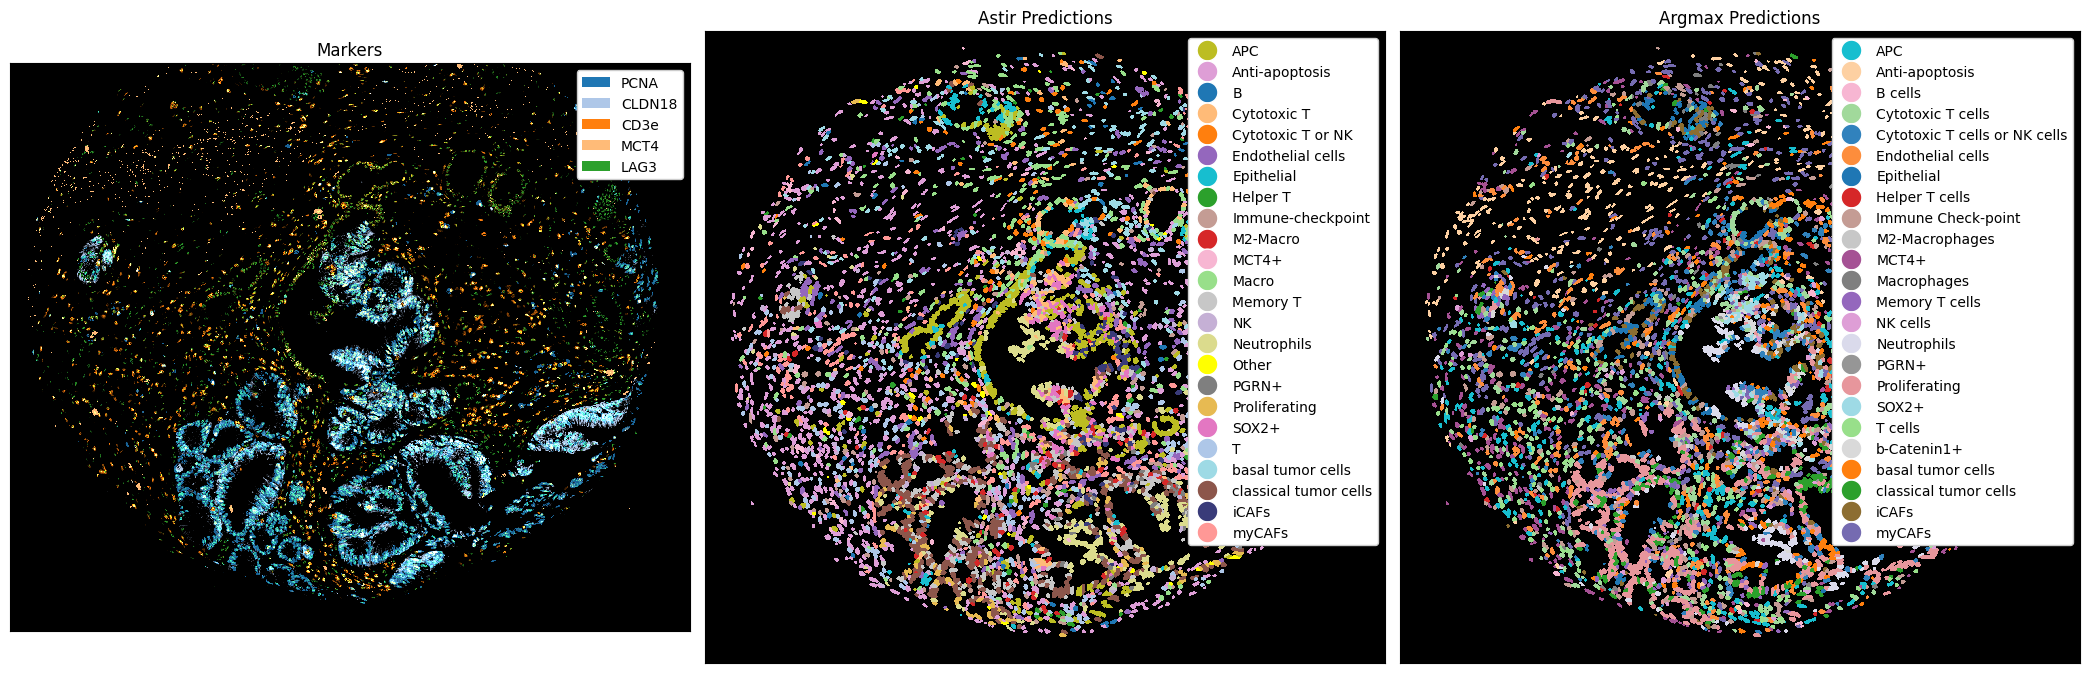

In [39]:

# plotting the astir and the argmax predictions
fig, ax = plt.subplots(1, 3, figsize=(21, 7))
_ = ds_2_4.pp[channels_celltypes].pl.colorize(colors).pl.autocrop(padding=100).pl.show(ax=ax[0])
_ = ds_with_ct_predictions_astir_2_4.pl.autocrop(padding=100).pl.show(render_image=False, render_labels=True, ax=ax[1])
_ = ds_2_4_predictions.pl.autocrop(padding=100).pl.show(render_image=False, render_labels=True, ax=ax[2])

# removing the x and y ticks
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[2].set_xticks([])
ax[2].set_yticks([])

# setting titles
ax[0].set_title("Markers")
ax[1].set_title("Astir Predictions")
ax[2].set_title("Argmax Predictions")

plt.tight_layout()

KeyboardInterrupt: 

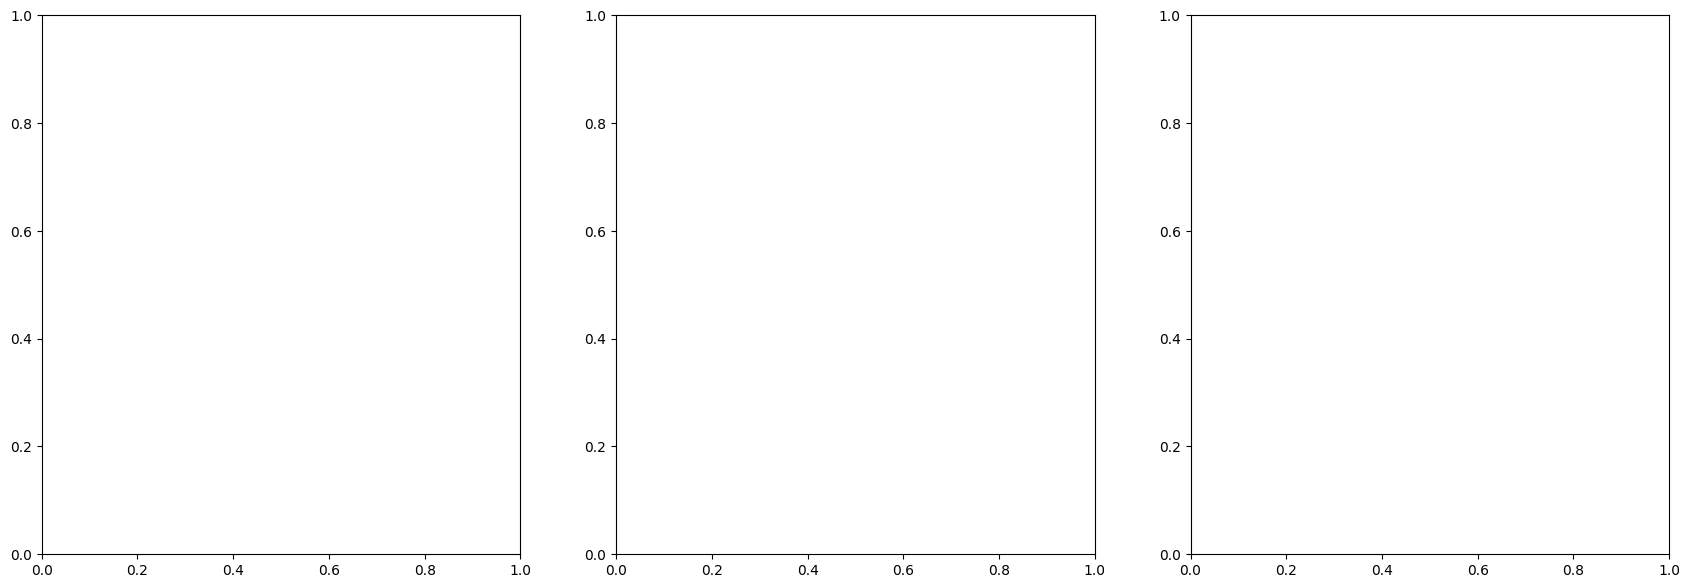

In [40]:
# plotting the astir and the argmax predictions
fig, ax = plt.subplots(1, 3, figsize=(21, 7))
_ = ds_5_5.pp[channels_celltypes].pl.colorize(colors).pl.autocrop(padding=100).pl.show(ax=ax[0])
_ = ds_with_ct_predictions_astir_5_5.pl.autocrop(padding=100).pl.show(render_image=False, render_labels=True, ax=ax[1])
_ = ds_5_5_predictions.pl.autocrop(padding=100).pl.show(render_image=False, render_labels=True, ax=ax[2])

# removing the x and y ticks
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[2].set_xticks([])
ax[2].set_yticks([])

# setting titles
ax[0].set_title("Markers")
ax[1].set_title("Astir Predictions")
ax[2].set_title("Argmax Predictions")

plt.tight_layout()

In [54]:
ds_5_5

<xarray.Dataset> Size: 398MB
Dimensions:                     (channels: 40, y: 2792, x: 3084, cells: 6517,
                                 features: 2)
Coordinates:
  * cells                       (cells) int64 52kB 1 2 3 4 ... 6515 6516 6517
  * channels                    (channels) <U15 2kB 'DAPI' 'SOX2' ... 'LAG3'
  * features                    (features) <U10 80B 'centroid-0' 'centroid-1'
  * x                           (x) int64 25kB 0 1 2 3 4 ... 3080 3081 3082 3083
  * y                           (y) int64 22kB 0 1 2 3 4 ... 2788 2789 2790 2791
Data variables:
    _image                      (channels, y, x) uint8 344MB dask.array<chunksize=(5, 349, 771), meta=np.ndarray>
    _intensity                  (cells, channels) float64 2MB dask.array<chunksize=(1630, 20), meta=np.ndarray>
    _obs                        (cells, features) float64 104kB dask.array<chunksize=(6517, 2), meta=np.ndarray>
    _segmentation               (y, x) uint16 17MB dask.array<chunksize=(349, 771), meta=np.ndarray>
    _segmentation_stardist_5_5  (y, x) int32 34MB dask.array<chunksize=(349, 771), meta=np.ndarray>

In [62]:
sp_dict = {"1": ds_with_ct_predictions_astir_2_4, "2": ds_with_ct_predictions_astir_5_5}


In [70]:
sp_dict_1 = {"1": ds_2_4_predictions, "2": ds_5_5_predictions}


In [63]:
image_container = sp.ImageContainer(sp_dict)


In [71]:
image_container_1 = sp.ImageContainer(sp_dict_1)


In [64]:
sp_dict = image_container.compute_neighborhoods()


In [72]:
sp_dict_1 = image_container_1.compute_neighborhoods()


Neighborhood Neighborhood 5 not found in the data object. Skipping.
Neighborhood Neighborhood 5 not found in the data object. Skipping.


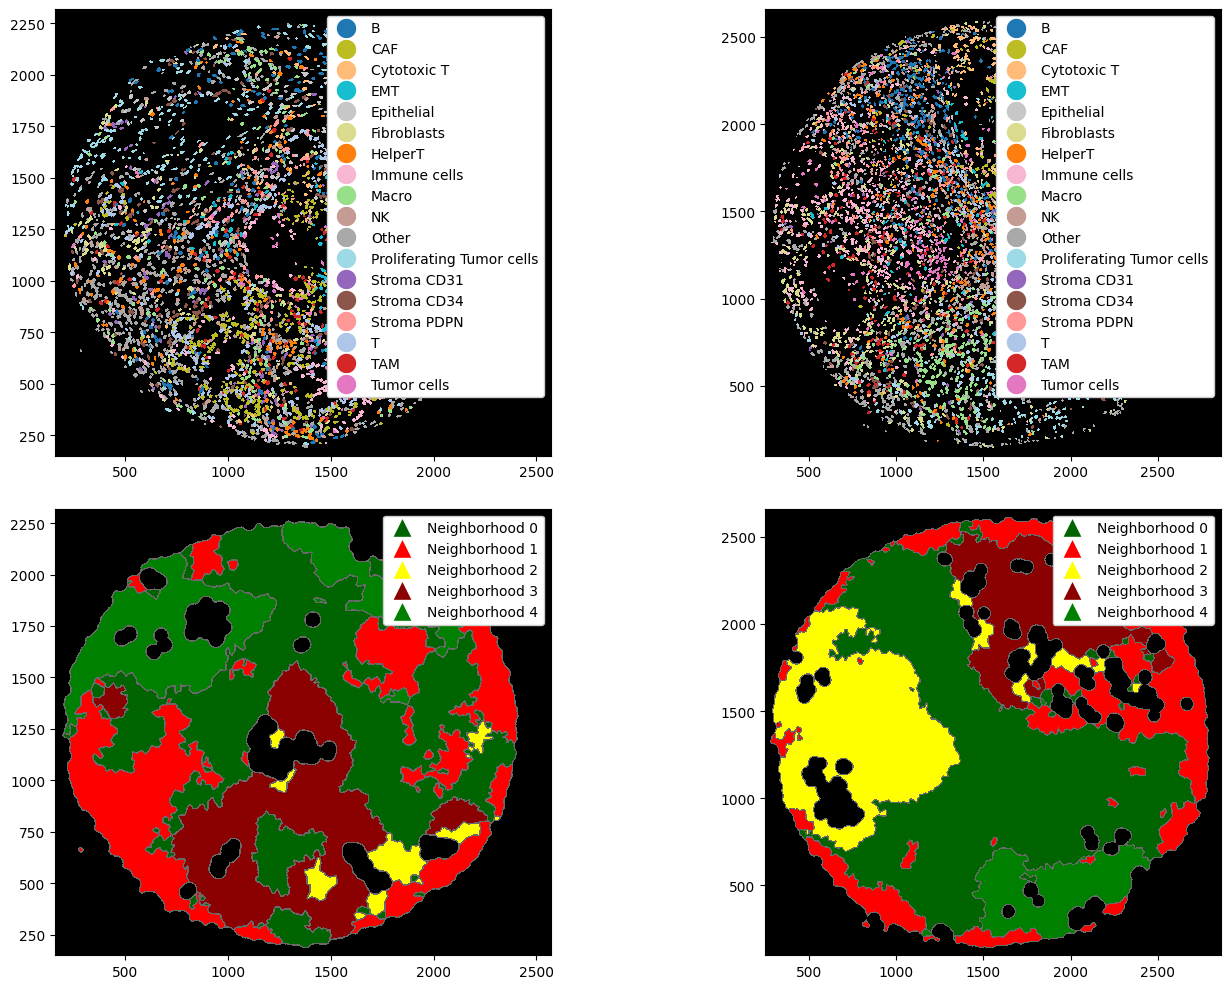

In [68]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
ax = ax.flatten()

# setting custom colors to be more in line with the cell types
neighborhoods = [f"Neighborhood {x}" for x in np.arange(6)]
colors = ["darkgreen", "red", "yellow", "darkred", "green", "blue"]  # 这里增加一个颜色

# plotting labels
_ = sp_dict["1"].pl.autocrop().pl.show(render_image=False, render_labels=True, ax=ax[0])
_ = sp_dict["2"].pl.autocrop().pl.show(render_image=False, render_labels=True, ax=ax[1])

# plotting neighborhoods
_ = (
    sp_dict["1"]
    .pl.autocrop()
    .nh.set_neighborhood_colors(neighborhoods, colors)
    .pl.show(render_image=False, render_neighborhoods=True, ax=ax[2])
)
_ = (
    sp_dict["2"]
    .pl.autocrop()
    .nh.set_neighborhood_colors(neighborhoods, colors)
    .pl.show(render_image=False, render_neighborhoods=True, ax=ax[3])
)

plt.tight_layout()

Neighborhood Neighborhood 5 not found in the data object. Skipping.
Neighborhood Neighborhood 5 not found in the data object. Skipping.


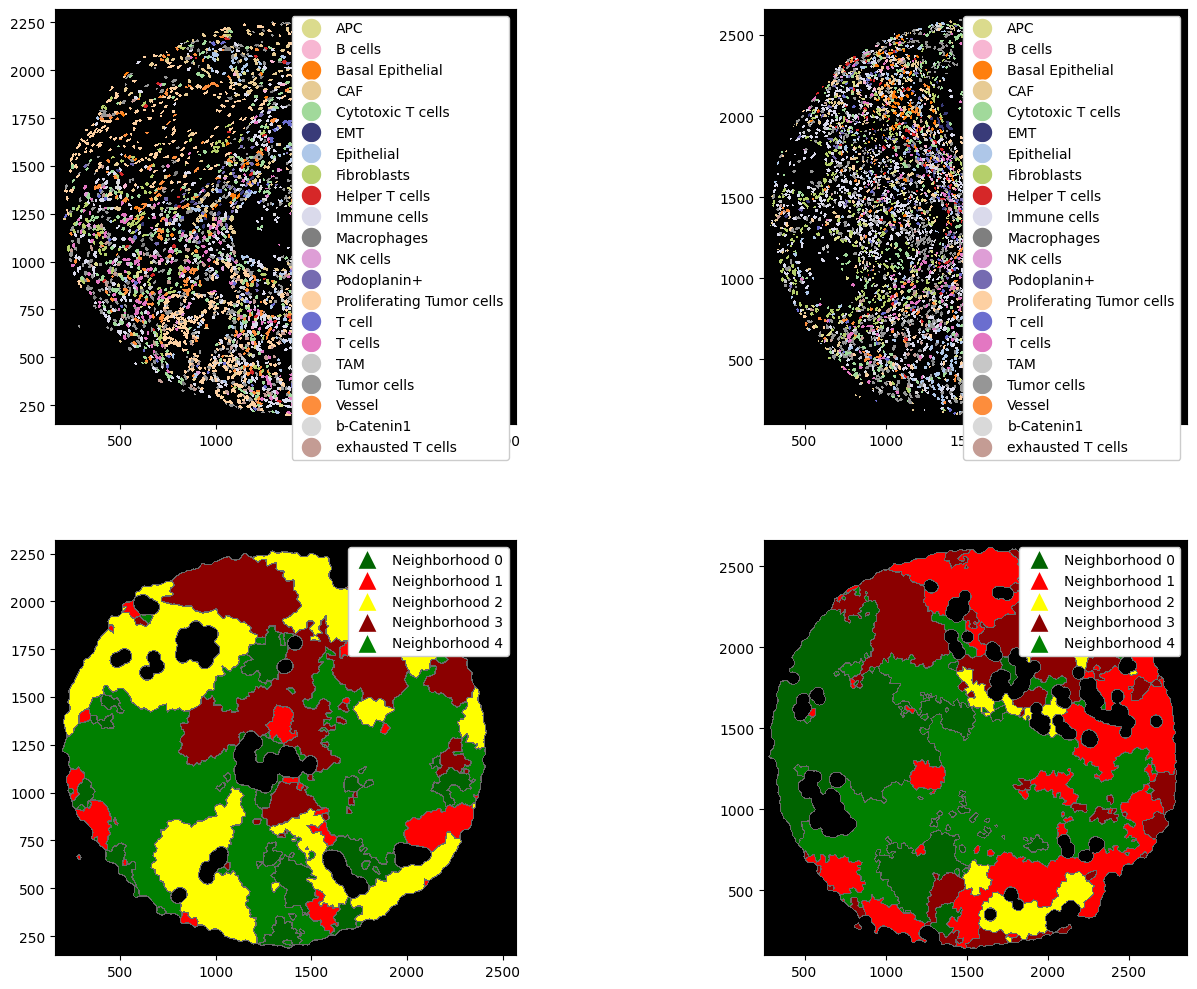

In [73]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
ax = ax.flatten()

# setting custom colors to be more in line with the cell types
neighborhoods = [f"Neighborhood {x}" for x in np.arange(6)]
colors = ["darkgreen", "red", "yellow", "darkred", "green", "blue"]  # 这里增加一个颜色

# plotting labels
_ = sp_dict_1["1"].pl.autocrop().pl.show(render_image=False, render_labels=True, ax=ax[0])
_ = sp_dict_1["2"].pl.autocrop().pl.show(render_image=False, render_labels=True, ax=ax[1])

# plotting neighborhoods
_ = (
    sp_dict_1["1"]
    .pl.autocrop()
    .nh.set_neighborhood_colors(neighborhoods, colors)
    .pl.show(render_image=False, render_neighborhoods=True, ax=ax[2])
)
_ = (
    sp_dict_1["2"]
    .pl.autocrop()
    .nh.set_neighborhood_colors(neighborhoods, colors)
    .pl.show(render_image=False, render_neighborhoods=True, ax=ax[3])
)

plt.tight_layout()

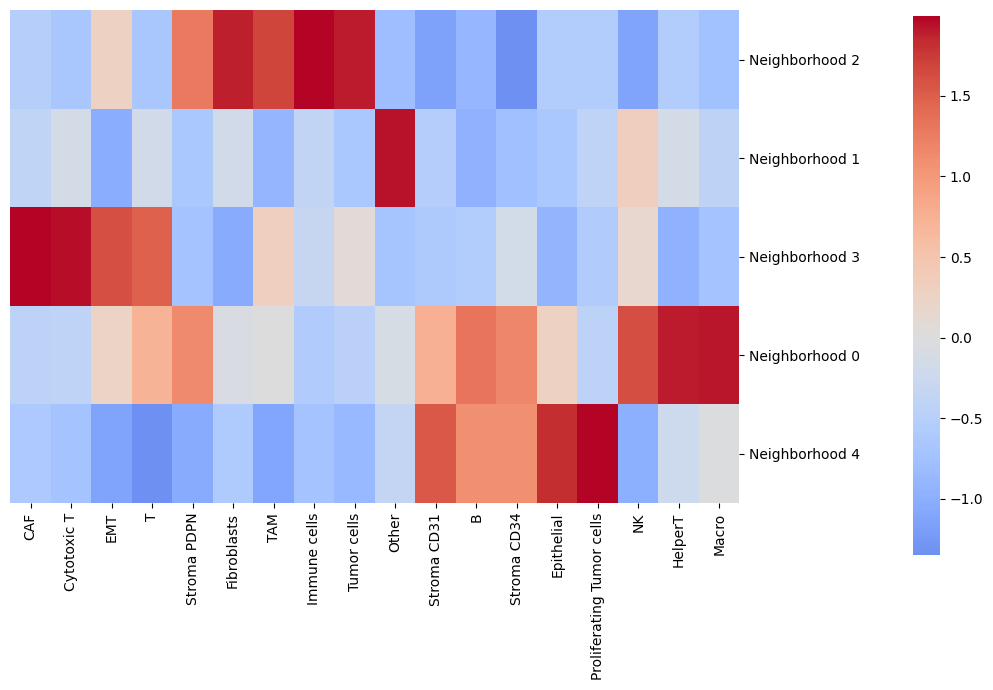

In [69]:
# obtaining a data frame containing the neighborhood compositions
nh_composition = image_container.get_neighborhood_composition()

# plotting the neighborhood composition as a seaborn clustermap
cluster_map = sns.clustermap(
    nh_composition,
    cmap="coolwarm",
    cbar_pos=(1.02, 0.2, 0.03, 0.77),  # Position the colorbar to the right of the heatmap
    dendrogram_ratio=(0.00001, 0),  # Remove row dendrogram
    figsize=(9, 7),  # Adjust the size
    annot=False,  # No annotation
    center=0,  # Setting the center of the colorbar to 0
)

# customizations of the plot
cluster_map.ax_heatmap.set_ylabel("")
plt.show()

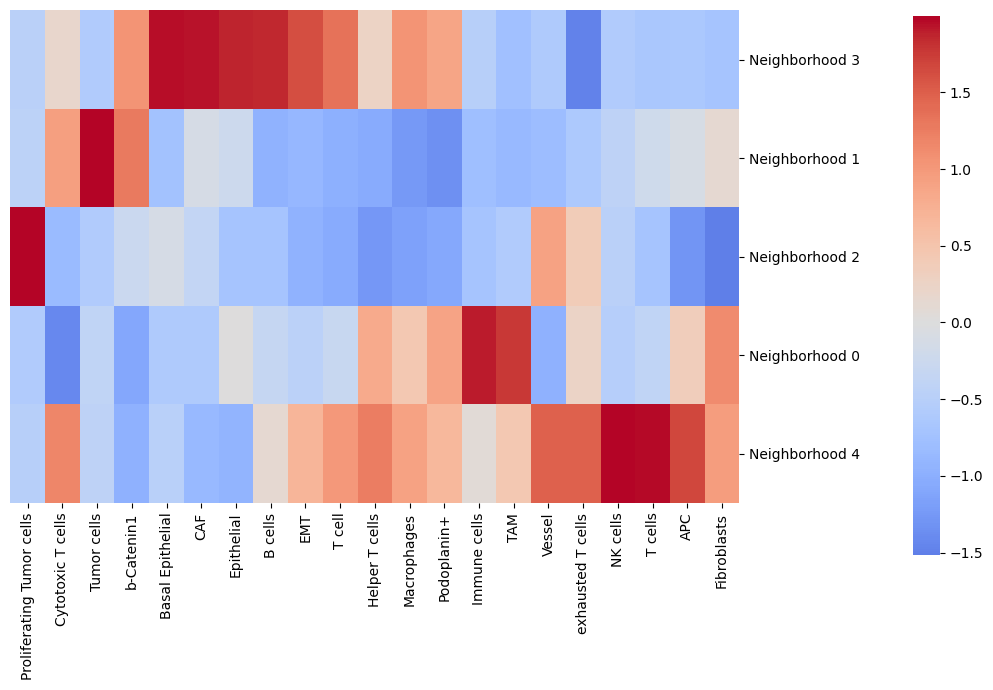

In [74]:
# obtaining a data frame containing the neighborhood compositions
nh_composition_1 = image_container_1.get_neighborhood_composition()

# plotting the neighborhood composition as a seaborn clustermap
cluster_map_1 = sns.clustermap(
    nh_composition_1,
    cmap="coolwarm",
    cbar_pos=(1.02, 0.2, 0.03, 0.77),  # Position the colorbar to the right of the heatmap
    dendrogram_ratio=(0.00001, 0),  # Remove row dendrogram
    figsize=(9, 7),  # Adjust the size
    annot=False,  # No annotation
    center=0,  # Setting the center of the colorbar to 0
)

# customizations of the plot
cluster_map_1.ax_heatmap.set_ylabel("")
plt.show()